In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import os.path as op

In [2]:
path = '../../data/kaggle-titanic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
setNames = ['train_RescaleClean.csv','train_label.csv','test_RescaleClean.csv']
data = []
for sn in setNames:
    data.append( pd.read_csv(op.join(path,sn)))
    print(data[-1].head())
    print(data[-1].info())

../data/kaggle-titanic/train_label.csv
../data/kaggle-titanic/test_RescaleClean.csv
../data/kaggle-titanic/train_RescaleClean.csv
../data/kaggle-titanic/test.csv
../data/kaggle-titanic/train.csv
   Unnamed: 0  Pclass  Sex  SibSp  Parch  Fare_group  Embarked  Age_group  \
0           0     1.0  0.0  0.125    0.0         0.0       0.0        0.2   
1           1     0.0  1.0  0.125    0.0         0.0       0.5        0.4   
2           2     1.0  1.0  0.000    0.0         0.0       0.0        0.2   
3           3     0.0  1.0  0.125    0.0         0.0       0.0        0.4   
4           4     1.0  0.0  0.000    0.0         0.0       0.0        0.4   

   Title  
0    0.0  
1    0.0  
2    1.0  
3    0.0  
4    0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  891 non-null    int64  
 1   Pclass      891 non-null    float64
 2   Sex

In [17]:
# simple model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X, y = data[0], data[1]['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
np.round(accuracy_score(y_test, y_pred),4)

0.8444

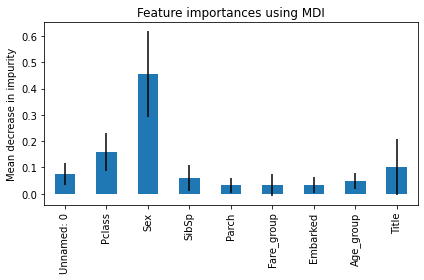

In [18]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=data[0].columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The model predicts a mean test_accuracy of 82.7166%, with a standard deviation of 3.5569%.


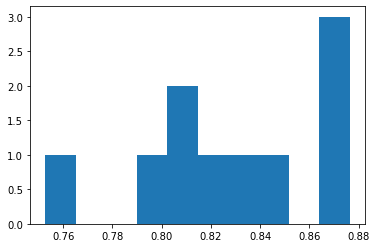

The model predicts a mean test_recall of 70.7731%, with a standard deviation of 9.6113%.


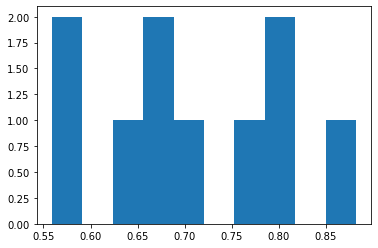

The model predicts a mean test_roc_auc of 86.1841%, with a standard deviation of 4.9321%.


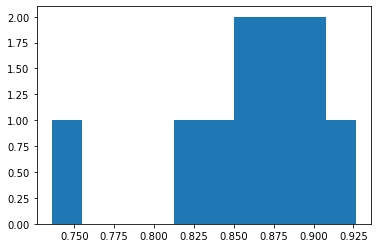

The model predicts a mean test_f1 of 75.5647%, with a standard deviation of 6.1036%.


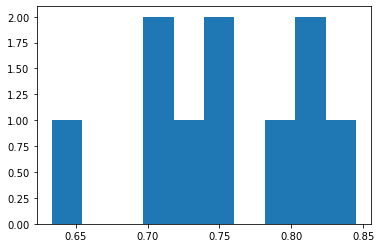

In [4]:
# cross validate simple model
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores = cross_validate(clf, X, y, cv=10, scoring=['accuracy', 'recall','roc_auc', 'f1'])

for tag in ['test_accuracy','test_recall', 'test_roc_auc', 'test_f1']:
    
    plt.clf()
    z = scores[tag]
    msr = np.mean(z)
    std = np.std(z)
    print(f'The model predicts a mean {tag} of {np.round(100*msr,4)}%, with a standard deviation of {np.round(100*std,4)}%.')
    im = plt.hist(z)
    plt.show()

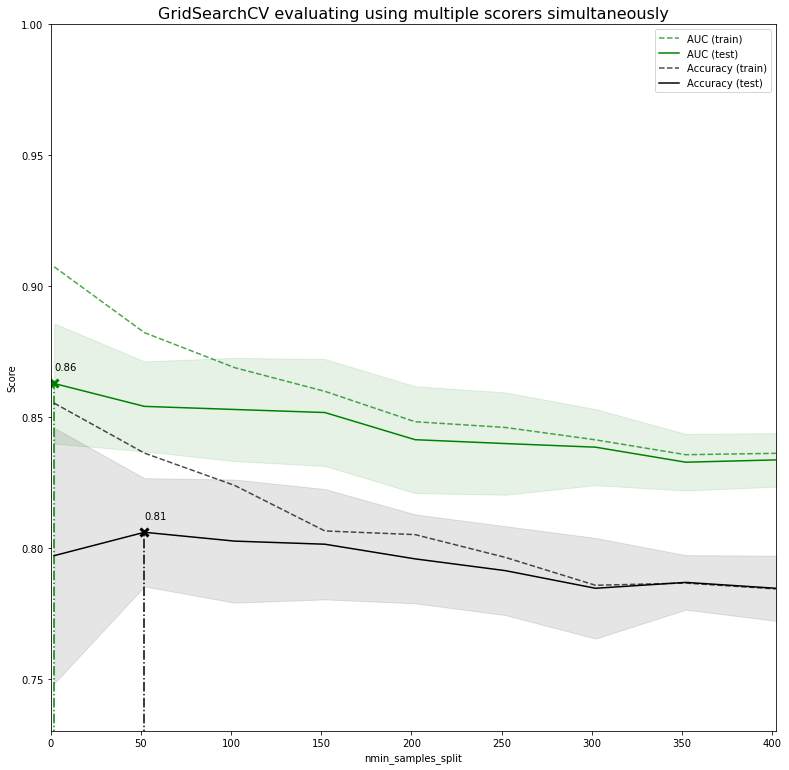

In [5]:
# tune parameters in simple model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=1
)

# Setting refit='AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with parameters like ``gs.best_score_``, ``gs.best_params_`` and ``gs.best_index_``
gs = GridSearchCV(
    clf,
    param_grid = { "min_samples_split": range(2, 403, 50)},
    scoring=scoring,
    refit="AUC",
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel('nmin_samples_split')
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [6]:
# # tune parameters ingrid of simple model
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score

# scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
# clf = RandomForestClassifier(
#     max_depth=5, 
#     random_state=1
# )

# # Setting refit='AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score.
# # That estimator is made available at ``gs.best_estimator_`` along with parameters like ``gs.best_score_``, ``gs.best_params_`` and ``gs.best_index_``
# numE = range(40,301,10)
# numSplit = range(2, 203, 10)
# gs = GridSearchCV(
#     clf,
#     param_grid = {'n_estimators':numE, "min_samples_split": numSplit},
#     scoring=scoring,
#     refit="AUC",
#     return_train_score=True,
# )
# gs.fit(X, y)
# results = gs.cv_results_

# for scorer in sorted(scoring):
#     print(scorer)
    
#     for sample in ['train', 'test']:
#         print(sample)
#         if sample=='test':
#             best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
#             best_score = results["mean_test_%s" % scorer][best_index]
#             best_paras = results['params'][best_index]
#             print(f'Best score: {best_score}')
#             print(f'Best parameters: {best_paras}')
        
#         sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
#         Z = sample_score_mean.reshape(-1,len(numSplit))
#         fig, ax = plt.subplots()
#         im = ax.imshow(Z,
#                        interpolation='bilinear',
#                        vmax=abs(Z).max(),
#                        vmin=abs(Z).min(),
#                        origin='lower', extent=[np.min(numE), np.max(numE), np.min(numSplit), np.max(numSplit)]
#                       )
#         fig.colorbar(im, ax=ax)

#         plt.show()

AUC
test
Best score: 0.856660644313569
Best parameters: {'min_samples_split': 33, 'max_depth': 84}


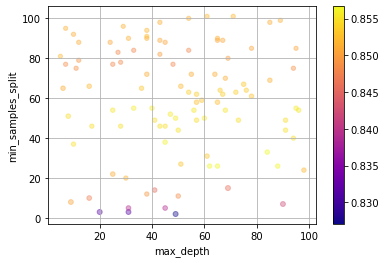

Accuracy
test
Best score: 0.8170610758897746
Best parameters: {'min_samples_split': 63, 'max_depth': 54}


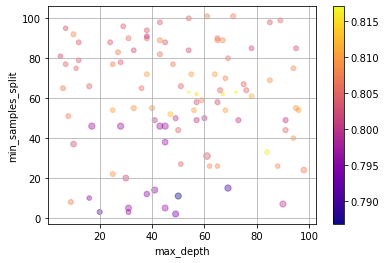

In [11]:
# tune parameters in search of simple model
from sklearn.model_selection import RandomizedSearchCV

numD = range(2,101,1)
numSplit = range(2, 103,1)
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=1
)

# Setting refit='AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with parameters like ``gs.best_score_``, ``gs.best_params_`` and ``gs.best_index_``

search = RandomizedSearchCV(
    clf,
    param_distributions = {"max_depth": numD, "min_samples_split": numSplit},
    scoring=scoring,
    refit="AUC",
    n_iter=100,
    random_state=0
)

search.fit(X, y)
results = search.cv_results_

xs = results["param_max_depth"]
ys = results["param_min_samples_split"]
import matplotlib as mpl
cmap = mpl.cm.plasma

for scorer in sorted(scoring):
    print(scorer)
    
    for sample in ['train', 'test']:
       
        if sample=='test':
            print(sample)
            best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
            best_score = results["mean_test_%s" % scorer][best_index]
            best_paras = results['params'][best_index]
            print(f'Best score: {best_score}')
            print(f'Best parameters: {best_paras}')
        
            mz = results["mean_%s_%s" % (sample, scorer)]
            mstd = results["std_%s_%s" % (sample, scorer)]

            fig, ax = plt.subplots()
            im = ax.scatter(xs,ys,s=1000*mstd, c=mz, cmap =cmap, alpha=0.4, vmin=np.min(mz), vmax=np.max(mz))
            
            norm = mpl.colors.Normalize(vmin=np.min(mz), vmax=np.max(mz))
            fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax)
            
            ax.grid(True)
            ax.set_xlabel('max_depth')
            ax.set_ylabel('min_samples_split')

            plt.show()

In [9]:
# stagged models